In [7]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [149]:
import numpy as np 
import sys
from scipy.integrate import odeint
import time
from numpy.random import *

class ca1_spine:
    """Computational biophysical model of CA1 spine"""
    #### Global constants:
    rtol = 1e-6
    atol = 1e-6 
    F = 96485.33 ## Coulomb/mole
    Nav = 6.022e23
    e = 2.718
    ############## Defining constant parameters ##################
    ## Spine compartment and ER size:
    #Vspine = 0.06 ## um^3, nominal spine volume
    Vr = 0.1 ## Ver/Vspine

    def __init__(self, g_N, nRyR, nip3, tau_refill, Vspine): #add ksk if required
        """initialize the spine parameters and volume/surface area-dependent constants: 
        params: (nmda conductance (pS), #ryr, tau_refill (s), Vspine(um^3))"""
        self.g_N = float(g_N) * 1e-12 #S
        self.nRyR = int(nRyR)
        self.ip3r_tot = int(nip3)
        self.tau_refill = float(tau_refill)
        #self.Vscale = float(Vscale)
        #self.k_sk = float(k_sk)
        self.Vspine = float(Vspine) ## in um^3
        self.d_spine = (6*self.Vspine/3.14)**0.333  ## um
        self.Aspine = 3.14 * self.d_spine**2 * 1e-8  ## cm^2
        self.Vspine = self.Vspine * 1e-15 ## liter
        self.Aer = 0.1 * self.Aspine  ## cm^2
        self.Ver = 0.1 * self.Vspine ## liter
        self.Vspine -= self.Ver   ## liter
        #self.Vspine_um - self.Vspine * 1e15 ##um^3 for scaling AMPA conductance
            ## Total concentration of PMCA and NCX pumps in the spine head (uM):
        self.pHtot = (1e14) * 1000 * self.Aspine/(self.Nav * self.Vspine)
        self.pLtot = (1e14) * 140 * self.Aspine/(self.Nav * self.Vspine)
                ######################################################################################
        self.g_N_Ca = 0.1 * (self.g_N/(2*self.F*78.0*self.ca_ext)) * 1e6   ## Ca conductance of NMDAR channels; liter/sec
        self.k_erleak = self.Vmax_serca * (self.ca_0**2)/((self.Kd_serca**2 + self.ca_0**2)*(self.ca_er_0 - self.ca_0))  ## /s




    ## Parameters for endogenous immobile buffer (CBP): 
    kbuff_f = 247 ## /uM/s
    kbuff_b = 524 ## /s

    ## Parameters for endogenous slow buffer:
    kslow_f = 24.7 ## /uM/s
    kslow_b = 52.4 ## /s

    ## Parameters for calbindin-Ca2+ kinetics:
    km0m1=174 ## /uM/s
    km1m2=87 ## /uM/s
    km1m0=35.8 ## /s
    km2m1=71.6 ## /s
    kh0h1=22 ## /uM/s
    kh1h2=11 ## /uM/s
    kh1h0=2.6 ## /s
    kh2h1=5.2 ## /s

    ## Parameters for PMCA and NCX pumps:
    k1H,k2H,k3H,kH_leak = [150,15,12,3.33]  ## (/uM/s, /s, /s, /s)
    k1L,k2L,k3L,kL_leak = [300,300,600,10]  ## (/uM/s, /s, /s, /s)

    ## Parameters for CaM-Ca2+ interaction:
    k1c_on = 6.8  ## /uM/s
    k1c_off = 68  ## /s
    k2c_on = 6.8 ## /uM/s
    k2c_off = 10 ## /s
    k1n_on = 108 ## /uM/s
    k1n_off = 4150 ## /s
    k2n_on = 108 ## /uM/s
    k2n_off = 800 ## /s

    ## Membrane and leak parameters:
    Cmem = 1e-6 ##  F/cm^2
    g_L = 2e-4  ## S/cm^2
    E_L = -70   ## mV

    ## AMPA receptor parameters:
    tau_A1 = 0.2e-3 ## s
    tau_A2 = 2e-3  ## s
    E_A = 0  ## mV
    g_A = 0.5e-9  ## S

    ## NMDA receptor parameters:
    tau_N1 = 5e-3 ## s
    tau_N2 = 50e-3 ## s
    E_N = 0  ## mV
    #g_N = 65e-12 ## S
    # insert NMDA conductance #

    ## L-VGCC parameters:
    um = -20 ## mV
    kmv = 5  ## mV
    tau_mv = 0.08e-3 ## sec
    uh = -65  ## mV
    khv = -7 ## mV
    tau_hv = 300e-3  ## sec

    ## Spine neck parameters:
    Rneck = 1e8  ## Ohm
    gc = 1.0/Rneck ## S
    rho_spines = 0  ## Surface density of co-active synaptic inputs on dendritic compartment (cm^-2)

    ## SERCA kinetic parameters:
    Vmax_serca = 1  ## uM/sec
    Kd_serca = 0.2 ## uM

    ## Parameters for Ca2+-based plasticity model:
    P1,P2,P3,P4 = [5.0,10.0,0.001,2]
    beta1,beta2 = [0.091,0.31]  ## /uM
    alpha1,alpha2 = [0.20,34.25] ## uM
    eta1, eta2 = [2, 10]
    omega_0 = 1.8 ## offset
    
    ## Thresholds set for canonical spine of volume 0.06 um^3

    ######################### ER Buffer Calreticulin Parameters ####################################
    #### Site C ####
    Kdiss_c = 2e3 #uM
    Scer = 20 #mol Ca/mol
    kcerf = 0.1 #uM^-1 s^-1

    #### Site P ####
    Kdiss_p = 10 #uM
    Sp = 1 #mol Ca/mol
    kpf = 100 #uM^-1 s^-1

    kcerb = kcerf * Kdiss_c
    kpb = kpf * Kdiss_p 

    ################# ER Buffer ###########################
    totBer_0 = 3.6e3 #uM
    totBcer = Scer * totBer_0 #uM
    totBper = Sp * totBer_0 #uM
    #buff_flag = 1

    ###############################################################################################
    ############################################ SOCC Model ##########################################
    ############################################################### Defining parameters ######################################################
    V_socc_max = 1.57 #um/s per channel max flux
    K_socc = 50 #um/s
    tau_socc = 30 #s
    n_socc = 4 #Hill coefficient
    socc_clus = 10 # no of socc channels
    ###########################################################################################################################################



    #########################################################
    ########### Concentrations of various species ###########
    #########################################################

    ## External Ca (uM):
    ca_ext = 2e3

    ## Resting cytosolic Ca (uM):ip3
    ca_0 = 0.05

    ## Resting Ca in ER (uM):
    ca_er_0 = 250#300#460#1.21E4#1.182e4#250 

    ## Total calbindin concentration in spine (uM):
    calb_tot = 45

    ## Total CBP concentration in the spine (uM):
    cbp_tot = 80

    ## Total slow buffer concentration in the spine (uM):
    Bslow_tot = 40



    ## Total concentration of CaM in spine (uM):
    cam_tot = 50


    #########################################################################################
    ################ RyR ########################################
    #### The model consists of a gating scheme consisting of 5 closed states and 2 open states ####
    #################### Rate Constants ###################################
    kon = 712.0 #1/(uM.s)
    koff = 3000.0 #### units of all the quantities hereafter is s^-1 ######
    kc4o1 = 10000.0 
    kc4o2 = 1
    ko1c4 = 500
    ko2c4 = 0.5
    ko1c5 = 2.0
    ko2c5 = 3000.0
    kc5o1 = 0.6666
    kc5o2 = 100.0
    kc5I  = 0.5
    kIc5 = 1.5
    kRc1 = 4*kon
    kc1R = koff
    kc1c2 = 3*kon
    kc2c1 = 2*koff
    kc2c3 = 2*kon
    kc3c2 = 3*koff
    kc3c4 = kon
    kc4c3 = 4*koff
    ##########################################################
    ######## RyR parameters (play around these to make sure everyting works well together) ##########
    gRyR = 18.5 #s^-1  ## Johenning's data -> see analysis
    ####################################################################################
    ################### SK Channel parameters ##########################################
    # tau_sk = 6.3e-3 #s
    # n_sk = 4
    # g_sk = 25e-12 #S
    # E_sk = -90 #mV
    ###################################################################################
    ################################ IP3 params #######################################
    ############################### Reaction parameters for mGluR_IP3 pathway:
    PIP2 = 4000  ## uM
    a1f = 11.1 ## /uM/s
    a1b = 2  ## 100 /s
    a2f = 11.1 ## /uM/s
    a2b = 2  ## 100 /s
    a3f = 2 ## /uM/s
    a3b = 100 ## /s
    a4f = 2 ## /uM/s
    a4b = 100 ## /s
    a5 = 116  ## 116 /s
    a6 = 0.001 ## /s
    a7 = 0.02 ## /s
    a8 = 6 ## /s
    b1f = 300 ## /uM/s
    b1b = 100 ## /s
    b2f = 900 ## /uM/s
    b2b = 30 ## /s
    b3f = 800 ## /uM/s
    b3b = 40 ## /s
    b4f = 1200 ## /uM/s
    b4b = 6 ## /s
    b5f = 1200 ## /uM/s
    b5b = 6 ## /s
    b6 = 2 ## /s
    b7 = 160 ## /s
    b8f = 1 ## /uM/s
    b8b = 170 ## /s
    b9f = 1 ## /uM/s
    b9b = 170 ## /s
    b10 = 8 ## /s
    b11 = 2  ## 8 /s
    b12 = 8 ## /s
    DAGdegrate = 0.15 ## /s

    ## Parameters for IP3R model (Fink et al., 2000 and Vais et al., 2010):
    Kinh = 0.2  ## uM
    d1 = 0.8 ## uM
    d5 = 0.3 ## uM
    a2 = 2.7 ## /uM/s
    alpha_ip3r = (0.15/3.2)*(1e7)*(1e6)/500.0  ## /uM/sec
    
        ## Total concentrations of IP3 3-kinase and IP3 5-phosphatase in the spine (uM):
    ip5pconc = 1
    ip3kconc = 0.9

    ## Number of IP3R:
#     ip3r_tot = int(float(30))

    ############################################################################
    ##############################################################################################
    #### Temporal profile of glutamate availability:
    def glu(self, t, flag):
        """temporal profile of glutamate availability"""
        #print("in glu function")
        if flag == 0:
            return 0
        else:
            self.tau_glu = 1e-3 #sec
            self.glu_0 = 2.718 * 300 #um

            total = 0

            for tpuff in self.tpre:
                if t > tpuff: total += self.glu_0 * np.exp(-(t-tpuff)/self.tau_glu) * ((t-tpuff)/self.tau_glu)
            return total

        ##############################################################################################

        ##############################################################################################
        #### Voltage profile of BAP at the dendritic compartment:
        ##Use this to get the voltage of the spine whenever required
    def u_bpap(self, t):
        """generates bAPs (for STDP). Not used for RDP/theta-burst"""

        V0 = 67
        total = 0

        for tbp in tpost:
            if t > tbp: total += V0 * (0.7 * np.exp(-(t - tbp)/0.003) + 0.3 * np.exp(-(t - tbp)/0.04))
        return self.E_L + total

    ##############################################################################################    
    #### AMPAR conductance profile: 
    def I_A(self,flag,u,t):
        """use this function to get AMPA current"""
        #print("in AMPA current")

        if flag==0:
            return 0
        else:
            total = 0
            for tpuff in self.tpre:
                if t>tpuff: total += self.g_A * (np.exp(-(t-tpuff)/self.tau_A2) - np.exp(-(t-tpuff)/self.tau_A1))  
            return total * (u - self.E_A)


    def I_N(self, flag, u, t):
        """use this function to get the NMDA receptor current"""
        #print("in NMDA current")

        if flag == 0:
            return 0

        else:
            total = 0
            for tpuff in self.tpre:
                if t > tpuff : total+= self.g_N * (np.exp(-(t - tpuff)/self.tau_N2) - np.exp(-(t - tpuff)/self.tau_N1))
            return total * (u - self.E_N)/(1 + 0.28 * np.exp(-0.062 * u))

#############################################################################################################33
############### SK Channel Hill function ###########################################
    def sk_inf(self, x):
        """SK-Hill function. args: cytosolic_calcium """
        return np.power(x, self.n_sk)/(np.power(x, self.n_sk) + np.power(self.k_sk, self.n_sk))


##############################################################################################        
#### Plasticity model, Omega function

    def omega(self, x):
        """defines the Omega function to classify LTP/LTD based on induction var x"""
        U = -self.beta2 * (x - self.alpha2)
        V = -self.beta1 * (x - self.alpha1)

        if U > 100: U = 100
        if V > 100: V = 100
        return self.omega_0 + (self.eta2/(1. + np.exp(U))) - (self.eta1/(1 + np.exp(V)))

#############################################################################################
#### Plasticity model Omega function	

    def omega_tau(self, x):
        """defines the tau function for synaptic weight change"""
        return self.P1 + (self.P2/(self.P3 + (2 * x /(self.alpha1 + self.alpha2))**self.P4))

#######################################################################
##### Coupled ODEs describing ER bearing spine head ###################
    def spine_model(self,x,t, vsp, ga):
        """ODE-based CA1 spine model"""


        pH, pL, cbp, Bslow, calb, calb_m1, calb_h1, calb_m2, calb_h2, calb_m1h1, calb_m2h1, calb_m1h2, c1n0, c2n0, c0n1, c0n2, c1n1, c2n1, c1n2, c2n2, R_Gq, Gact,IP3,ca_Gact_PLC_PIP2,DAGdegr,\
        PLC_PIP2,DAG,IP3_IP5P,IP3degr,glu_R_Gq,Gbc,ca_PLC,IP3_IP3K_2ca,R,ca_PLC_PIP2,IP3K_2ca,Gact_PLC_PIP2,Gq,IP5P,GaGDP,ca_Gact_PLC,glu_R,IP3K, mv, hv, w, u, ud, h,\
        ca_er, ca, R, c1, c2, c3, c4, c5, o1, o2, Bcer, Bper, p_socc = x
        ###########|----------- RyR ----------|   |-Buffer-|  |-socc-|##############
        
        ########################### changing AMPA conductance and volume with weights ####################################
        vsp *= w
        ga *= ga
        aspine = np.power(vsp * 1e15, float(2/3)) * np.power(36 * np.pi, float(1/3)) * 1e-8 ## cm^2
        #print(w)

        nt = self.glu(t,self.flag)
        #print(self.flag)

#         if (self.flag>0 and self.input_pattern=='stdp'): 
#             ud = self.u_bpap(t)




        p_socc_inf = np.power(self.K_socc,self.n_socc)/(np.power(self.K_socc,self.n_socc) + np.power(ca_er, self.n_socc))
        dPdt = (p_socc_inf - p_socc)/self.tau_socc



        ## RyR Kinetics:#################################################
        Jrel = self.gRyR  * (o1 + o2) * (ca_er - ca)
        ######################### Channel Ca Release ########################################
        ca_eq = self.nRyR * Jrel * self.Vr + self.V_socc_max * self.socc_clus * p_socc 
        ca_er_eq = - self.nRyR * Jrel  + (self.ca_er_0 - ca_er)/self.tau_refill
        ########################################################################################################################
        #print("ca: ryr {}".format(ca))
        ##########################################################################################################
        ################################### IP3 ###################################
        R_Gq_eq = -self.a2f*R_Gq*nt + self.a2b*glu_R_Gq + self.a3f*R*Gq-self.a3b*R_Gq
        Gact_eq = +self.a5*glu_R_Gq+self.a6*Gq - self.a7*Gact-self.b3f*Gact*PLC_PIP2 + self.b3b*Gact_PLC_PIP2 - self.b4f*Gact*ca_PLC_PIP2 + self.b4b*ca_Gact_PLC_PIP2 - self.b5f*ca_PLC*Gact + self.b5b*ca_Gact_PLC
        IP3_eq = +self.b6*ca_PLC_PIP2 + self.b7*ca_Gact_PLC_PIP2 - 100*IP3K_2ca*IP3 + 80*IP3_IP3K_2ca - 12.5*IP5P*IP3 + 72*IP3_IP5P ## change multiplier to IP5P*IP3 term to 9 for Gaurang's model
        ca_Gact_PLC_PIP2_eq = +self.b2f*ca*Gact_PLC_PIP2 - self.b2b*ca_Gact_PLC_PIP2 + self.b4f*Gact*ca_PLC_PIP2 - self.b4b*ca_Gact_PLC_PIP2 - self.b11*ca_Gact_PLC_PIP2 + self.b9f*ca_Gact_PLC*self.PIP2 - self.b9b*ca_Gact_PLC_PIP2 - self.b7*ca_Gact_PLC_PIP2
        DAGdegr_eq = +self.DAGdegrate*DAG
        PLC_PIP2_eq = -self.b1f*ca*PLC_PIP2 + self.b1b*ca_PLC_PIP2 - self.b3f*Gact*PLC_PIP2+self.b3b*Gact_PLC_PIP2 + self.b10*Gact_PLC_PIP2
        DAG_eq = +self.b6*ca_PLC_PIP2 + self.b7*ca_Gact_PLC_PIP2 - self.DAGdegrate*DAG
        IP3_IP5P_eq = +9*IP5P*IP3 - 72*IP3_IP5P - 18*IP3_IP5P
        IP3degr_eq = +20*IP3_IP3K_2ca + 18*IP3_IP5P
        glu_R_Gq_eq = +self.a2f*R_Gq*nt - self.a2b*glu_R_Gq + self.a4f*glu_R*Gq - self.a4b*glu_R_Gq-self.a5*glu_R_Gq
        Gbc_eq = +self.a5*glu_R_Gq + self.a6*Gq - self.a8*GaGDP*Gbc
        ca_PLC_eq = -self.b8f*ca_PLC*self.PIP2 + self.b8b*ca_PLC_PIP2 + self.b6*ca_PLC_PIP2 - self.b5f*ca_PLC*Gact + self.b5b*ca_Gact_PLC + self.b12*ca_Gact_PLC
        IP3_IP3K_2ca_eq = +100*IP3K_2ca*IP3-80*IP3_IP3K_2ca-20*IP3_IP3K_2ca
        R_eq = -self.a1f*R*nt + self.a1b*glu_R - self.a3f*R*Gq + self.a3b*R_Gq
        ca_PLC_PIP2_eq = +self.b1f*ca*PLC_PIP2 - self.b1b*ca_PLC_PIP2 - self.b4f*Gact*ca_PLC_PIP2 + self.b4b*ca_Gact_PLC_PIP2 + self.b11*ca_Gact_PLC_PIP2 + self.b8f*ca_PLC*self.PIP2 - self.b8b*ca_PLC_PIP2 - self.b6*ca_PLC_PIP2
        IP3K_2ca_eq = +1111*IP3K*ca*ca - 100*IP3K_2ca - 100*IP3K_2ca*IP3 + 80*IP3_IP3K_2ca + 20*IP3_IP3K_2ca
        Gact_PLC_PIP2_eq = -self.b2f*ca*Gact_PLC_PIP2 + self.b2b*ca_Gact_PLC_PIP2 + self.b3f*Gact*PLC_PIP2 - self.b3b*Gact_PLC_PIP2 - self.b10*Gact_PLC_PIP2
        Gq_eq = -self.a3f*R*Gq + self.a3b*R_Gq - self.a4f*glu_R*Gq + self.a4b*glu_R_Gq - self.a6*Gq + self.a8*GaGDP*Gbc
        IP5P_eq = -9*IP5P*IP3+72*IP3_IP5P+18*IP3_IP5P
        GaGDP_eq = +self.a7*Gact - self.a8*GaGDP*Gbc + self.b10*Gact_PLC_PIP2 + self.b11*ca_Gact_PLC_PIP2 + self.b12*ca_Gact_PLC
        ca_Gact_PLC_eq = -self.b9f*ca_Gact_PLC*self.PIP2 + self.b9b*ca_Gact_PLC_PIP2 + self.b7*ca_Gact_PLC_PIP2 + self.b5f*ca_PLC*Gact - self.b5b*ca_Gact_PLC - self.b12*ca_Gact_PLC
        glu_R_eq = +self.a1f*R*nt - self.a1b*glu_R - self.a4f*glu_R*Gq + self.a4b*glu_R_Gq + self.a5*glu_R_Gq
        IP3K_eq = -1111*IP3K*ca*ca+100*IP3K_2ca

        ca_eq += (-self.b1f*ca*PLC_PIP2 - self.b2f*ca*Gact_PLC_PIP2 - 1111*IP3K*ca*ca - 1111*IP3K*ca*ca + (self.b1b*ca_PLC_PIP2 + self.b2b*ca_Gact_PLC_PIP2 + 100*IP3K_2ca + 100*IP3K_2ca)) 

        ## IP3 receptor kinetics:

        x = IP3/(IP3 + self.d1)
        y = ca/(ca + self.d5)
        Q2 = self.Kinh
        h_eq = self.a2*(Q2 - (Q2+ca)*h)

        ca_eq += self.ip3r_tot * ((x*y*h)**3) * self.alpha_ip3r * (ca_er - ca)/(self.Nav * vsp) 

        ca_er_eq += -self.alpha_ip3r * self.ip3r_tot * ((x*y*h)**3) * (ca_er - ca)/(self.Nav * vsp * 0.1) ## vsp * 0.1 = ver

        ## Buffer equations:

        Bslow_eq = -self.kslow_f*Bslow*ca + self.kslow_b*(self.Bslow_tot - Bslow)
        ca_eq += -self.kslow_f*Bslow*ca + self.kslow_b*(self.Bslow_tot - Bslow)

        cbp_eq = -self.kbuff_f*ca*cbp + self.kbuff_b*(self.cbp_tot - cbp)
        ca_eq += -self.kbuff_f*ca*cbp + self.kbuff_b*(self.cbp_tot - cbp)    

        calb_m2h2 = self.calb_tot - calb - calb_m1 - calb_h1 - calb_m2 - calb_h2 - calb_m1h1 - calb_m2h1 - calb_m1h2
        calb_eqs = [ -ca*calb*(self.km0m1 + self.kh0h1) + self.km1m0*calb_m1 + self.kh1h0*calb_h1,\
                         ca*calb*self.km0m1 - self.km1m0*calb_m1 + calb_m2*self.km2m1 - ca*calb_m1*self.km1m2 + calb_m1h1*self.kh1h0 - ca*calb_m1*self.kh0h1,\
                         ca*calb*self.kh0h1 - self.kh1h0*calb_h1 + calb_h2*self.kh2h1 - ca*calb_h1*self.kh1h2 + calb_m1h1*self.km1m0 - ca*calb_h1*self.km0m1,\
                         ca*calb_m1*self.km1m2 - self.km2m1*calb_m2 + self.kh1h0*calb_m2h1 - ca*self.kh0h1*calb_m2,\
                         ca*calb_h1*self.kh1h2 - self.kh2h1*calb_h2 + self.km1m0*calb_m1h2 - ca*self.km0m1*calb_h2,\
                         ca*(calb_h1*self.km0m1 + calb_m1*self.kh0h1) - (self.km1m0+self.kh1h0)*calb_m1h1 - ca*calb_m1h1*(self.km1m2+self.kh1h2) + self.kh2h1*calb_m1h2 + self.km2m1*calb_m2h1,\
                         ca*self.km1m2*calb_m1h1 - self.km2m1*calb_m2h1 + self.kh2h1*calb_m2h2 - self.kh1h2*ca*calb_m2h1 + self.kh0h1*ca*calb_m2 - self.kh1h0*calb_m2h1,\
                         ca*self.kh1h2*calb_m1h1 - self.kh2h1*calb_m1h2 + self.km2m1*calb_m2h2 - self.km1m2*ca*calb_m1h2 + self.km0m1*ca*calb_h2 - self.km1m0*calb_m1h2 ]
        ca_eq += -ca*(self.km0m1*(calb+calb_h1+calb_h2) + self.kh0h1*(calb+calb_m1+calb_m2) + self.km1m2*(calb_m1+calb_m1h1+calb_m1h2) + self.kh1h2*(calb_h1+calb_m1h1+calb_m2h1))+\
                    self.km1m0*(calb_m1+calb_m1h1+calb_m1h2) + self.kh1h0*(calb_h1+calb_m1h1+calb_m2h1) + self.km2m1*(calb_m2+calb_m2h1+calb_m2h2) + self.kh2h1*(calb_h2+calb_m1h2+calb_m2h2)
        #print("ca: calb {}".format(ca))
        #print(calb)
        ## Ca2+/calmodulin kinetics:

        c0n0 = self.cam_tot - c1n0 - c2n0 - c0n1 - c0n2 - c1n1 - c2n1 - c1n2 - c2n2
        c1n0_eq = -(self.k2c_on*ca + self.k1c_off + self.k1n_on*ca)*c1n0 + self.k1c_on*ca*c0n0 + self.k2c_off*c2n0 + self.k1n_off*c1n1
        c2n0_eq = -(self.k2c_off + self.k1n_on*ca)*c2n0 + self.k2c_on*ca*c1n0 + self.k1n_off*c2n1
        c0n1_eq = -(self.k2n_on*ca + self.k1n_off + self.k1c_on*ca)*c0n1 + self.k1n_on*ca*c0n0 + self.k2n_off*c0n2 + self.k1c_off*c1n1
        c0n2_eq = -(self.k2n_off + self.k1c_on*ca)*c0n2 + self.k2n_on*ca*c0n1 + self.k1c_off*c1n2
        c1n1_eq = -(self.k2c_on*ca + self.k1c_off + self.k1n_off + self.k2n_on*ca)*c1n1 + self.k1c_on*ca*c0n1 + self.k1n_on*ca*c1n0 + self.k2c_off*c2n1 + self.k2n_off*c1n2
        c2n1_eq = -(self.k2c_off + self.k2n_on*ca)*c2n1 + self.k2c_on*ca*c1n1 + self.k2n_off*c2n2 + self.k1n_on*ca*c2n0 - self.k1n_off*c2n1
        c1n2_eq = -(self.k2n_off + self.k2c_on*ca)*c1n2 + self.k2n_on*ca*c1n1 + self.k2c_off*c2n2 + self.k1c_on*ca*c0n2 - self.k1c_off*c1n2
        c2n2_eq = -(self.k2c_off + self.k2n_off)*c2n2 + self.k2c_on*ca*c1n2 + self.k2n_on*ca*c2n1
        cam_eqs = [c1n0_eq, c2n0_eq, c0n1_eq, c0n2_eq, c1n1_eq, c2n1_eq, c1n2_eq, c2n2_eq]
        ca_eq += -ca*(self.k1c_on*(c0n0+c0n1+c0n2) + self.k1n_on*(c0n0+c1n0+c2n0) + self.k2c_on*(c1n0+c1n1+c1n2) + self.k2n_on*(c0n1+c1n1+c2n1)) + self.k1c_off*(c1n0+c1n1+c1n2) + self.k1n_off*(c0n1+c1n1+c2n1) \
        + self.k2c_off*(c2n0+c2n1+c2n2) + self.k2n_off*(c0n2+c1n2+c2n2)
        #print("ca: cam {}".format(ca))

        ############################ ER Buffer kinetics #############################################################
        if self.buff_flag:
            dBcer_dt = -self.kcerf*(ca_er * Bcer) + self.kcerb * (self.totBcer - Bcer)
            dBper_dt = -self.kpf * (ca_er * Bper) + self.kpb * (self.totBper - Bper)
            ca_er_eq += -self.kcerf*(ca_er * Bcer) + self.kcerb * (self.totBcer - Bcer) -self.kpf * (ca_er * Bper) + self.kpb * (self.totBper - Bper)
        else:
            dBcer_dt = 0
            dBper_dt = 0
            ca_er_eq += 0

        ## PMCA/NCX kinetics:

        ca_eq += pH*self.kH_leak - ca*pH*self.k1H + self.k2H*(self.pHtot - pH)  +  pL*self.kL_leak - ca*pL*self.k1L + self.k2L*(self.pLtot - pL)
        pH_eq = self.k3H*(self.pHtot - pH) - ca*pH*self.k1H + self.k2H*(self.pHtot - pH)
        pL_eq = self.k3L*(self.pLtot - pL) - ca*pL*self.k1L + self.k2L*(self.pLtot - pL)
        #print("ca: pmca {}".format(ca))

          ## SERCA kinetics: 

        ca_eq += -self.Vmax_serca * ca**2/(self.Kd_serca**2 + ca**2) + self.k_erleak*(ca_er - ca)

        ## VGCC equatiosn:

        mv_eq = ((1.0/(1 + np.exp(-(u-self.um)/self.kmv))) - mv)/self.tau_mv
        hv_eq = ((1.0/(1 + np.exp(-(u-self.uh)/self.khv))) - hv)/self.tau_hv
        I_vgcc = -0.001 * self.Nav * 3.2e-19 * self.g_vgcc * (mv**2) * hv * 0.078 * u * (ca - self.ca_ext*np.exp(-0.078*u))/(1 - np.exp(-0.078*u))

        ## Spine and dendrite voltage eqns:


        sp_hh_eq = -(1/self.Cmem) * ( self.g_L*(u - self.E_L) + self.I_A(self.flag,u,t)/aspine + self.I_N(self.flag,u,t)/aspine - (self.gc/aspine)*(ud - u) - I_vgcc/aspine) #- self.g_sk * s_sk * (u - self.E_sk)
        dend_hh_eq = -(1/self.Cmem) * ( self.g_L*(ud - self.E_L) + self.rho_spines*self.gc*(ud - u))
        #print(self.I_A(self.flag,u,t)/self.Aspine)

        ## Ca2+ influx through NMDAR and VGCC:
        #print(u)

        ca_eq += -(self.g_N_Ca/vsp) * (self.I_N(self.flag,u,t)/(self.g_N*(u - self.E_N))) * 0.078 * u * (ca - self.ca_ext*np.exp(-0.078*u))/(1 - np.exp(-0.078*u)) \
                -(self.g_vgcc/vsp) * (mv**2) * hv * 0.078 * u * (ca - self.ca_ext*np.exp(-0.078*u))/(1 - np.exp(-0.078*u))   
        #print("ca: nmda/vgcc {}".format(ca))

        ################################## RyR Dynamics #################################################
        ryr_eqs = [-R*ca*self.kRc1 + c1*self.kc1R, -(self.kc1c2*ca+ self.kc1R)*c1 + c2*self.kc2c1 + self.kRc1*ca*R, -(self.kc2c3*ca + self.kc2c1)*c2 + self.kc3c2*c3 + self.kc1c2*ca*c1,\
                    -(self.kc3c4*ca + self.kc3c2)*c3 + self.kc2c3*ca*c2 + self.kc4c3*c4, -(self.kc4o1 + self.kc4o2 + self.kc4c3)*c4 + self.kc3c4*ca*c3 + self.ko1c4*o1 + self.ko2c4*o2,\
                    -(self.kc5o1 + self.kc5o2 + self.kc5I)*c5 + self.ko1c5*o1 + self.kIc5*(1-R-c1-c2-c3-c4-c5-o1-o2) + self.ko2c5*o2, -(self.ko1c5 + self.ko1c4)*o1 + self.kc4o1*c4 + self.kc5o1*c5,\
                     -(self.ko2c4 + self.ko2c5)*o2 + self.kc4o2*c4 + self.kc5o2*c5]

        ##################################################################################################

        ########################## SK - channel equations ################################################
        #dskdt = (self.sk_inf(ca) - s_sk)/self.tau_sk 

        ## Equation for plasticity variable w:
        acam = self.cam_tot - c0n0    
        w_eq = (1.0/self.omega_tau(acam))*(self.omega(acam) - w)
        #print(ca)

        #print('') [dRdt, dc1dt, dc2dt, dc3dt, dc4dt, dc5dt, do1dt, do2dt]
        #print([pH_eq, pL_eq, cbp_eq, Bslow_eq] + calb_eqs + cam_eqs + [mv_eq, hv_eq] + [w_eq] + [sp_hh_eq, dend_hh_eq,\
               # ca_er_eq, ca_eq] + ryr_eqs + [dBcer_dt, dBper_dt] + [dPdt] + [dskdt])

        return [pH_eq, pL_eq, cbp_eq, Bslow_eq] + calb_eqs + cam_eqs + [R_Gq_eq,Gact_eq,\
                IP3_eq,ca_Gact_PLC_PIP2_eq,DAGdegr_eq,PLC_PIP2_eq,DAG_eq,IP3_IP5P_eq,IP3degr_eq,glu_R_Gq_eq,Gbc_eq,ca_PLC_eq,IP3_IP3K_2ca_eq,\
                                                                        R_eq,ca_PLC_PIP2_eq,IP3K_2ca_eq,Gact_PLC_PIP2_eq,Gq_eq,IP5P_eq,GaGDP_eq,ca_Gact_PLC_eq,glu_R_eq,IP3K_eq] + [mv_eq, hv_eq] + [w_eq] + [sp_hh_eq, dend_hh_eq, h_eq, ca_er_eq, ca_eq] + ryr_eqs + [dBcer_dt, dBper_dt] + [dPdt] #+ [dskdt]

    ################################################################################################################
    ############################################### Experiments ##################################################
    ################### simulate ER+ spine without inputs to cnverge to steady state #############
    def get_resting_params(self):
        """simulates the spine in absence of inputs and returns the resting state params"""
        self.flag = 0
        self.buff_flag = 1 ## set buff_flag for using ER buffer
        self.g_vgcc = 0
        self.input_pattern="rdp"
        
        if (self.nRyR == 0 and self.ip3r_tot == 0):
            self.buff_flag = 0
            self.Vmax_serca = 0
            self.k_erleak = 0
            self.V_socc_max = 0
        ##########################################################################################################
        ######################## Initializing all variables:######################################################
        ########################################################################################################


        pumps_init = [self.pHtot, self.pLtot]
        buff_init =  [self.cbp_tot, self.Bslow_tot] + [self.calb_tot,0,0,0,0,0,0,0] 
        CaM_init = [0]*8  
        vgcc_init = [0,1] 
        w_init = [1] 
        voltage_init = [self.E_L, self.E_L]
        #ip3r_init = [1]
        ca_init = [self.ca_er_0, self.ca_0]
        RyR_init = [1/8]*8
        calreticulin_init = [63840,135]#[self.totBcer, self.totBper]#
        SOCC_init = [0.001]
        sk_init = [0.001]
        mGluR_init = [0,0,0,0,0,0.8,0,0,0,0,0,0,0,0.3,0,0,0,1.0,self.ip5pconc,0,0,0,self.ip3kconc]
        ip3r_init = [1]


        xinit0 = mGluR_init + pumps_init + buff_init + CaM_init + vgcc_init + w_init + voltage_init + ip3r_init + ca_init + RyR_init + calreticulin_init + SOCC_init 

        #print(xinit0)

        ################ solving #################################################
        t0 = np.arange(0., 500., 0.001)
        sol0 = odeint(self.spine_model, xinit0, t0, rtol=self.rtol, atol=self.atol, args=(self.Vspine, self.g_A))
        print("initial ER calcium = {}".format(sol0[-1,-13]))
        print("initial cyto calcium = {}".format(sol0[-1,-12]))


        return sol0[-1,:]


######################################### RDP ################################################################

    def do_rdp(self, f_input, n_inputs):
        """performs RDP 
        parameters: (frequency of stimulation, no. of presynaptic inputs)"""
        if (self.nRyR == 0 and self.ip3r_tot == 0):
            self.buff_flag = 0
            self.Vmax_serca = 0
            self.k_erleak = 0
            self.V_socc_max = 0
        
        xinit = self.get_resting_params()
        self.Vspine *= xinit[-17]
        self.flag = 1
        self.buff_flag = 1
        self.tpre = [i/float(f_input) for i in range(n_inputs)]
        t = np.linspace(min(self.tpre), max(self.tpre), 10000)
        sol = odeint(self.spine_model,xinit, t, args=(self.Vspine, self.g_A), rtol = self.rtol, atol = self.atol)
        ################ saving in a file ######################
        fname = "rdp_out_vinit{}_nryr{}_f{}.csv".format(round(self.Vspine * 1e15, 2), self.nRyR, f_input)
        return sol
    
    ########################################## theta-burst #################################################################
    def theta_burst(self, lam, mu, sd, n_turns):
        """performs theta-burst protocol: gives spine 100Hz stimulation. The no. of inputs for each burst are sampled from poisson distr with mean lam and the ISI's are sampled from a normal distribution of mean = mu and SD=sd
        params: lam: mean no. of inputs from poisson distr; mu, sd: mean and SD of normal distr, used to sample ISI; n_turns: no. of times the stim is applied"""
        seed(234534)
        
        if (self.nRyR == 0 and self.ip3r_tot == 0):
            self.buff_flag = 0
            self.Vmax_serca = 0
            self.k_erleak = 0
            self.V_socc_max = 0
            self.ip3r_tot = 0
            

        xinit = self.get_resting_params()
        self.flag = 1
        t_rest = normal(mu, sd, n_turns) ## gives resting time after each stim
        t_burst = np.cumsum(t_rest)
        t_burst = np.insert(t_burst, 0, 0) ## produce a spike at t = 0s
        t_burst = t_burst[:-1]
        nipArr = np.zeros(t_burst.shape[0]) ## array to store the no. of inputs during each burst
        
        print(t_rest)
        print(t_burst)
        
        self.flag = 1
        
        ###### simulating #####
        for i in range(int(t_rest.shape[0])):
            n_inputs = poisson(lam)
            nipArr[i] = n_inputs
            self.tpre = [t_burst[i] + (k/100.0) for k in range(int(n_inputs))]
            self.tpre = np.array(self.tpre)
            print(self.tpre)
            t = np.arange(np.amin(self.tpre), np.amax(self.tpre) + t_rest[i], 0.0001)
            print(t)
            sol = odeint(self.spine_model, xinit, t, args=(self.Vspine, self.g_A))
            xinit = sol[-1,:]
            sol = sol[::250,:]
            camTrace = [np.sum(sol[j, 13:20]) for j in range(sol.shape[0])]
            ################# saving in a file ###############
            ## File names:
            if self.nRyR: data = "real_erSpine_encoding_states_vinit{}.csv".format(round(self.Vspine * 1e15, 2))
            else: data = "real_NoErSpine_encoding_states_vinit{}.csv".format(round(self.Vspine * 1e15, 2))
            print(data)
            
            for x in range(sol.shape[0]):
                with open(data, "a+") as f:
                    f.write("{},{},{} \n".format(float(sol[x,-16]), float(sol[x, -12]), float(camTrace[x])))
                    f.close()
        return sol
        
        
        
    

In [155]:
sp1 = ca1_spine(65,40,30,1.0,0.06)
sp2 = ca1_spine(65,0,0,1.0,0.06)
sol = sp1.get_resting_params()
print("initial ip3 = {}".format(sol[22]))
sol = sp1.do_rdp(1,5)
sol0 = sp2.do_rdp(1,5)

initial ER calcium = 245.78185814605206
initial cyto calcium = 0.050213679184706234
initial ip3 = 0.11352513630774787
initial ER calcium = 245.78185814605206
initial cyto calcium = 0.050213679184706234
initial ER calcium = 250.0
initial cyto calcium = 0.049967273190555356


0.00023534118588423565


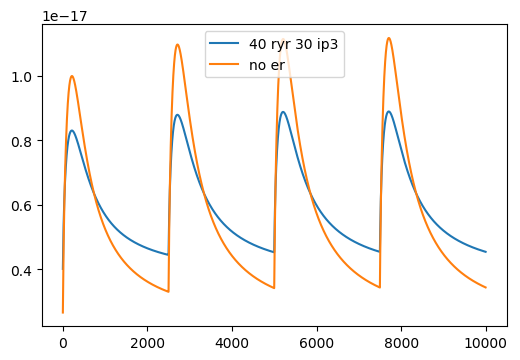

In [156]:
print(sp1.k_erleak)
plt.figure(dpi = 100)
plt.plot(sol[:,-12]*sp1.Vspine, label="40 ryr 30 ip3")
plt.plot(sol0[:,-12]*sp2.Vspine, label="no er")
plt.legend()

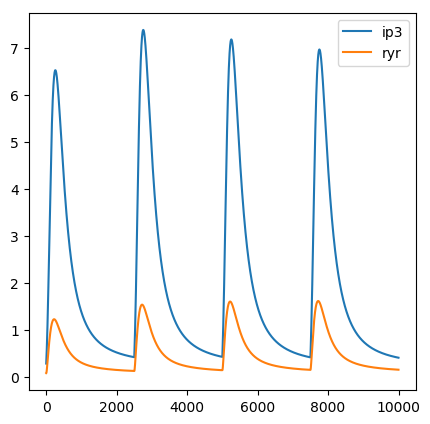

In [157]:
plt.figure(figsize=(5,5), dpi = 100)
ip3_open_prob = [((ip3/(ip3+sp1.d1))*(ca/(ca + sp1.d5))*h)**3 for ip3,ca,h in zip(sol[:,22],sol[:,-12],sol[:,-14])]
ip3r_flux = [sp1.alpha_ip3r * sp1.ip3r_tot * op * (ca_er - ca)/(sp1.Nav * sp1.Vspine * w) for op,ca_er,ca,w in zip(ip3_open_prob,sol[:,-13],sol[:,-12],sol[:,-17])]
ryr_flux = [sp1.gRyR * sp1.nRyR * (o1 + o2) * (caer - ca) for o1,o2,caer,ca in zip(sol[:,-4], sol[:,-5], sol[:,-13], sol[:,-12])]
plt.plot(ip3r_flux, label="ip3")
plt.plot(ryr_flux, label="ryr")
plt.legend()

In [41]:
sp1.alpha_ip3r

937499999.9999999

# Setting up the sims

In [142]:
nryrArr = np.array((0,40))
nip3Arr = np.array((0,30))
tauArr = np.array((0.1,1.0))
volArr = np.arange(0.3, 5.1, 0.1)*0.06

In [145]:
print(volArr)
print(len(volArr) * len(tauArr))

[0.018 0.024 0.03  0.036 0.042 0.048 0.054 0.06  0.066 0.072 0.078 0.084
 0.09  0.096 0.102 0.108 0.114 0.12  0.126 0.132 0.138 0.144 0.15  0.156
 0.162 0.168 0.174 0.18  0.186 0.192 0.198 0.204 0.21  0.216 0.222 0.228
 0.234 0.24  0.246 0.252 0.258 0.264 0.27  0.276 0.282 0.288 0.294 0.3  ]
96


In [148]:
params = []

for v in volArr:
    for t in tauArr:
        params.append("{}_{}_{}_{}_{}".format(float(65), 40, 30, t, v))
params

['65.0_40_30_0.1_0.018',
 '65.0_40_30_1.0_0.018',
 '65.0_40_30_0.1_0.024',
 '65.0_40_30_1.0_0.024',
 '65.0_40_30_0.1_0.03',
 '65.0_40_30_1.0_0.03',
 '65.0_40_30_0.1_0.036000000000000004',
 '65.0_40_30_1.0_0.036000000000000004',
 '65.0_40_30_0.1_0.04200000000000001',
 '65.0_40_30_1.0_0.04200000000000001',
 '65.0_40_30_0.1_0.048000000000000015',
 '65.0_40_30_1.0_0.048000000000000015',
 '65.0_40_30_0.1_0.054000000000000006',
 '65.0_40_30_1.0_0.054000000000000006',
 '65.0_40_30_0.1_0.06000000000000001',
 '65.0_40_30_1.0_0.06000000000000001',
 '65.0_40_30_0.1_0.06600000000000002',
 '65.0_40_30_1.0_0.06600000000000002',
 '65.0_40_30_0.1_0.07200000000000002',
 '65.0_40_30_1.0_0.07200000000000002',
 '65.0_40_30_0.1_0.07800000000000003',
 '65.0_40_30_1.0_0.07800000000000003',
 '65.0_40_30_0.1_0.08400000000000002',
 '65.0_40_30_1.0_0.08400000000000002',
 '65.0_40_30_0.1_0.09000000000000002',
 '65.0_40_30_1.0_0.09000000000000002',
 '65.0_40_30_0.1_0.09600000000000003',
 '65.0_40_30_1.0_0.09600000